In [1]:
import numpy as np # linear algebra
import pandas as pd# data processing, CSV file I/O (e.g. pd.read_csv)
import pickle

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
train = pd.read_csv('Train-1542865627584.csv');

In [3]:
outpatient= pd.read_csv("Train_Outpatientdata-1542865627584.csv")
inpatient= pd.read_csv("Train_Inpatientdata-1542865627584.csv")
beneficiary= pd.read_csv("Train_Beneficiarydata-1542865627584.csv")


In [4]:
def isCategorical(col):
    unis = np.unique(col)
    if len(unis)<0.02*len(col):
        return True
    return False


def getColumnTypes(cols):
    Categorical=[]
    Numerical = []
    Object = []
    for i in range(len(cols)):
        if cols["type"][i]=='categorical':
            Categorical.append(cols['column_name'][i])
        elif cols["type"][i]=='numerical':
            Numerical.append(cols['column_name'][i])
        else:
            Object.append(cols['column_name'][i])
    return Categorical, Numerical, Object

def isNumerical(col):
    return is_numeric_dtype(col)

def genMetaData(df):
    col = df.columns
    ColumnType = [] 
    Categorical = []
    Object = []
    Numerical = []
    for i in range(len(col)):
        if isCategorical(df[col[i]]):
            ColumnType.append((col[i],"categorical"))
            Categorical.append(col[i])
        
        elif is_numeric_dtype(df[col[i]]):
            ColumnType.append((col[i],"numerical"))
            Numerical.append(col[i])
        
        else:
            ColumnType.append((col[i],"object"))
            Object.append(col[i])

    return ColumnType

def makeMapDict(col): 
    uniqueVals = list(np.unique(col))
    uniqueVals.sort()
    dict_ = {uniqueVals[i]: i for i in range(len(uniqueVals))}
    return dict_

def mapunique(df, colName):
    dict_ = makeMapDict(df[colName])
    cat = np.unique(df[colName])
    df[colName] =  df[colName].map(dict_)
    return cat 


def newDF(df, columns2Drop):
    newDF = df.drop(columns2Drop, axis = 'columns')
    return newDF

def convert_df(df):
    return df.to_csv().encode('utf-8')



In [5]:
beneficiary['DOB'] = pd.to_datetime(beneficiary['DOB'] , format = '%Y-%m-%d')
beneficiary['DOD'] = pd.to_datetime(beneficiary['DOD'],format = '%Y-%m-%d',errors='ignore')
beneficiary['Age'] = round(((beneficiary['DOD'] - beneficiary['DOB']).dt.days)/365)

## As we see that last DOD value is 2009-12-01 ,which means Beneficiary Details data is of year 2009.
## so we will calculate age of other benficiaries for year 2009.

In [6]:
beneficiary.Age.fillna(round(((pd.to_datetime('2009-12-01' , format = '%Y-%m-%d') - beneficiary['DOB']).dt.days)/365),
                                 inplace=True)

In [7]:
## Creating the master DF
inpatient['EncounterType'] = 0
outpatient['EncounterType'] = 1
frames = [inpatient, outpatient]
TrainInAndOut = pd.concat(frames)
TrainInAndOutBenf = pd.merge(TrainInAndOut, beneficiary, how='inner', on='BeneID')
Master_df = pd.merge(TrainInAndOutBenf, train, how='inner', on='Provider')

In [8]:
Master_df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,PotentialFraud
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,1,2,1,1,36000,3204,60,70,67.0,Yes
1,BENE16973,CLM565430,2009-09-06,2009-09-06,PRV55912,50,PHY365867,PHY327147,NaN,NaN,...,1,2,2,2,24000,2136,450,200,78.0,Yes
2,BENE17521,CLM34721,2009-01-20,2009-02-01,PRV55912,19000,PHY349293,PHY370861,PHY363291,2009-01-20,...,1,2,2,2,19000,1068,100,20,96.0,Yes
3,BENE21718,CLM72336,2009-10-17,2009-11-04,PRV55912,17000,PHY334706,PHY334706,NaN,2009-10-17,...,1,1,2,2,17000,1068,1050,540,87.0,Yes
4,BENE22934,CLM73394,2009-10-25,2009-10-29,PRV55912,13000,PHY390614,PHY323689,PHY363291,2009-10-25,...,1,1,1,2,27000,2136,450,160,79.0,Yes


In [9]:
Master_df['PotentialFraud'].value_counts()

No     345415
Yes    212796
Name: PotentialFraud, dtype: int64

In [10]:
## removing the column DOD and DOB also creating a new column IsDead as we already have the age we do not need date of death and date of birth 

Master_df.loc[Master_df['DOD'].isnull(), 'IsDead'] = '0'
Master_df.loc[(Master_df['DOD'].notnull()), 'IsDead'] = '1'
Master_df = Master_df.drop(['DOD'], axis = 1)
Master_df = Master_df.drop(['DOB'], axis = 1)

Calculating the number of days the patient was admitted to the dospital and removing admission and discharge date, For outpatients as they do not get admitted will put number of days admitted = 0

In [11]:
Master_df['AdmissionDt'] = pd.to_datetime(Master_df['AdmissionDt'] , format = '%Y-%m-%d')
Master_df['DischargeDt'] = pd.to_datetime(Master_df['DischargeDt'],format = '%Y-%m-%d')
Master_df['DaysAdmitted'] = ((Master_df['DischargeDt'] - Master_df['AdmissionDt']).dt.days)+1
Master_df.loc[Master_df['EncounterType'] == 1, 'DaysAdmitted'] = '0'
Master_df[['EncounterType','DaysAdmitted','DischargeDt','AdmissionDt']].head()
Master_df = Master_df.drop(['DischargeDt'], axis = 1)
Master_df = Master_df.drop(['AdmissionDt'], axis = 1)

In [12]:
Master_df.loc[Master_df['DeductibleAmtPaid'].isnull(), 'DeductibleAmtPaid'] = '0'

In [13]:
cols= ['ClmAdmitDiagnosisCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_10',
       'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
       'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6']

In [14]:
Master_df[cols]= Master_df[cols].replace({np.nan:0})
Master_df

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmAdmitDiagnosisCode,...,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,PotentialFraud,IsDead,DaysAdmitted
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,7866,...,1,1,36000,3204,60,70,67.0,Yes,0,7.0
1,BENE16973,CLM565430,2009-09-06,2009-09-06,PRV55912,50,PHY365867,PHY327147,NaN,0,...,2,2,24000,2136,450,200,78.0,Yes,0,0
2,BENE17521,CLM34721,2009-01-20,2009-02-01,PRV55912,19000,PHY349293,PHY370861,PHY363291,45340,...,2,2,19000,1068,100,20,96.0,Yes,0,13.0
3,BENE21718,CLM72336,2009-10-17,2009-11-04,PRV55912,17000,PHY334706,PHY334706,NaN,V5789,...,2,2,17000,1068,1050,540,87.0,Yes,0,19.0
4,BENE22934,CLM73394,2009-10-25,2009-10-29,PRV55912,13000,PHY390614,PHY323689,PHY363291,71946,...,1,2,27000,2136,450,160,79.0,Yes,0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,BENE154147,CLM394122,2009-06-02,2009-06-04,PRV54050,500,PHY317497,NaN,PHY317497,0,...,2,2,0,0,890,120,85.0,No,0,0
558207,BENE154687,CLM184358,2009-02-08,2009-02-08,PRV54302,3300,PHY376238,PHY376238,NaN,99639,...,1,2,0,0,4400,220,83.0,No,0,0
558208,BENE157378,CLM460770,2009-07-09,2009-07-29,PRV51577,2100,PHY338096,NaN,NaN,0,...,2,2,0,0,14240,2810,64.0,No,0,0
558209,BENE158295,CLM306999,2009-04-16,2009-04-16,PRV53083,10,PHY416646,NaN,NaN,0,...,1,2,0,0,640,350,85.0,No,0,0


In [15]:
for i in cols:
    Master_df[i][Master_df[i]!=0]= 1

C:\Users\302201\AppData\Local\Temp/ipykernel_1592/1718562570.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Master_df[i][Master_df[i]!=0]= 1


In [16]:
Master_df[cols]= Master_df[cols].astype(float)

In [17]:
Master_df['TotalDiagnosis']= Master_df['ClmDiagnosisCode_1']+Master_df['ClmDiagnosisCode_10']+Master_df['ClmDiagnosisCode_2']+ Master_df['ClmDiagnosisCode_3']+ Master_df['ClmDiagnosisCode_4']+Master_df['ClmDiagnosisCode_5']+ Master_df['ClmDiagnosisCode_6']+ Master_df['ClmDiagnosisCode_7']+Master_df['ClmDiagnosisCode_8']+ Master_df['ClmDiagnosisCode_9']

In [18]:
Master_df['TotalProcedure']= Master_df['ClmProcedureCode_1']+Master_df['ClmProcedureCode_2']+Master_df['ClmProcedureCode_3']+ Master_df['ClmProcedureCode_4']+ Master_df['ClmProcedureCode_5']+Master_df['ClmProcedureCode_6']

Removing coulmns which are not necessary

In [19]:
Master_df.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmAdmitDiagnosisCode', 'DeductibleAmtPaid',
       'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'EncounterType', 'Gender',
       'Race', 'RenalDiseaseIndicator', 'State', 'County',
       'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_I

In [20]:
remove=['Provider','BeneID', 'ClaimID', 'ClaimStartDt','ClaimEndDt','AttendingPhysician',
       'OperatingPhysician', 'OtherPhysician', 'ClmDiagnosisCode_1',
       'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
       'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
       'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3',
       'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6',
       'ClmAdmitDiagnosisCode','DeductibleAmtPaid','NoOfMonths_PartACov',
        'NoOfMonths_PartBCov','DiagnosisGroupCode',
        'State', 'County']

In [21]:
Master_df.drop(columns=remove, axis=1, inplace=True)

In [22]:
Master_df.shape

(558211, 26)

In [23]:
Master_df['RenalDiseaseIndicator'].value_counts()

0    448363
Y    109848
Name: RenalDiseaseIndicator, dtype: int64

In [24]:
Master_df['RenalDiseaseIndicator']= Master_df['RenalDiseaseIndicator'].replace({'Y':1,'0':0})

In [25]:
Master_df['RenalDiseaseIndicator']=Master_df['RenalDiseaseIndicator'].astype(int)

In [26]:
Master_df.describe(include='O')

,PotentialFraud,IsDead,DaysAdmitted
count,558211,558211,558211
unique,2,2,37
top,No,0,0
freq,345415,554080,517737


In [27]:
Master_df['IsDead']=Master_df['IsDead'].astype(float)
Master_df['DaysAdmitted']=Master_df['DaysAdmitted'].astype(float)

In [28]:
Master_df['PotentialFraud']=Master_df['PotentialFraud'].replace({'Yes':1, 'No':0})

In [29]:
 Master_df['PotentialFraud']=Master_df['PotentialFraud'].astype(int)

In [30]:
Master_df['PotentialFraud']

0         1
1         1
2         1
3         1
4         1
         ..
558206    0
558207    0
558208    0
558209    0
558210    0
Name: PotentialFraud, Length: 558211, dtype: int32

In [31]:
df_5 = Master_df.sample(frac = 0.05)
 
# Creating dataframe with
# rest of the 95% values
df_95 = Master_df.drop(df_5.index)

In [32]:
x= df_95.drop('PotentialFraud', axis=1)
y= df_95.loc[:,'PotentialFraud']

In [33]:
Master_df.shape

(558211, 26)

In [34]:
x_unseen = df_5.drop("PotentialFraud",axis=1)
x_unseen.to_csv("main_data.csv")

In [35]:
x_unseen = df_5.drop("PotentialFraud",axis=1)
x_unseen.to_csv("main_data.csv",index=False)

In [36]:
from sklearn.preprocessing import StandardScaler

In [37]:
x.columns

Index(['InscClaimAmtReimbursed', 'EncounterType', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age', 'IsDead',
       'DaysAdmitted', 'TotalDiagnosis', 'TotalProcedure'],
      dtype='object')

# Train- Test Split

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
x.shape

(530300, 25)

In [40]:
y.shape

(530300,)

## ANN 

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
# We are transforming data to numpy array to implementing with keras
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [42]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
model = Sequential([
    Dense(units=20, input_dim = X_train.shape[1], activation='relu'),
    Dense(units=24,activation='relu'),
    Dropout(0.5),
    Dense(units=20,activation='relu'),
    Dense(units=24,activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                520       
                                                                 
 dense_1 (Dense)             (None, 24)                504       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_2 (Dense)             (None, 20)                500       
                                                                 
 dense_3 (Dense)             (None, 24)                504       
                                                                 
 dense_4 (Dense)             (None, 1)                 25        
                                                                 
Total params: 2,053
Trainable params: 2,053
Non-trainabl

In [43]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=30, epochs=1)

12374/12374 [==============================] - 53s 4ms/step - loss: 2.1993 - accuracy: 0.6110


In [44]:
pickle.dump(model,open("ANN.pkl",'wb'))


INFO:tensorflow:Assets written to: ram://029323e3-6fcf-4a2c-ba88-84f21c79c6a3/assets


In [84]:
score = model.evaluate(X_test, y_test)
print('Test Accuracy: {:.2f}%\nTest Loss: {}'.format(score[1]*100,score[0]))

4972/4972 [==============================] - 6s 1ms/step - loss: 0.6646 - accuracy: 0.6190
Test Accuracy: 61.90%
Test Loss: 0.664554238319397


In [68]:
a=[1,2,3,4,5,6,7,8]
print(a[:-6:-2])
print(a[-1:2:-2])

[8, 6, 4]
[8, 6, 4]


[]

In [56]:
import numpy as np
a = np.array([[35, 53,63],[72, 12, 22],[43, 84, 56]])
a[1][:] = [20, 30, 40]
print(a)

[[35 53 63]
 [20 30 40]
 [43 84 56]]


[[35 53 63]
 [20 30 40]
 [43 84 56]]


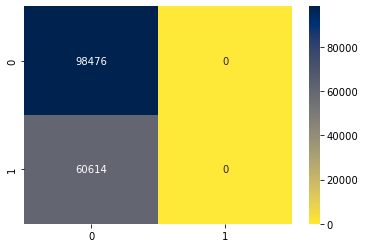

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(X_test)
y_test = pd.DataFrame(y_test)
cm = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm, annot=True, fmt='.0f', cmap='cividis_r')
plt.show()

## ANN with SMOTE

In [90]:
from imblearn.over_sampling import SMOTE
X_smote, y_smote = SMOTE().fit_sample(x, y)
X_smote = pd.DataFrame(X_smote)
y_smote = pd.DataFrame(y_smote)
y_smote.iloc[:,0].value_counts()

1    328163
0    328163
Name: PotentialFraud, dtype: int64

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.3, random_state=0)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size = 30, epochs = 2)

Epoch 1/5
15315/15315 [==============================] - 23s 1ms/step - loss: 0.6935 - accuracy: 0.4998
Epoch 2/5
15315/15315 [==============================] - 22s 1ms/step - loss: 0.6932 - accuracy: 0.4988
Epoch 3/5
15315/15315 [==============================] - 22s 1ms/step - loss: 0.6932 - accuracy: 0.5010
Epoch 4/5
15315/15315 [==============================] - 22s 1ms/step - loss: 0.6932 - accuracy: 0.4995
Epoch 5/5
15315/15315 [==============================] - 22s 1ms/step - loss: 0.6932 - accuracy: 0.5004


In [92]:
score = model.evaluate(X_test, y_test)
print('Test Accuracy: {:.2f}%\nTest Loss: {}'.format(score[1]*100,score[0]))

6154/6154 [==============================] - 7s 1ms/step - loss: 0.6932 - accuracy: 0.4997
Test Accuracy: 49.97%
Test Loss: 0.6931777596473694


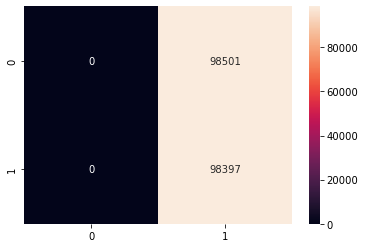

In [93]:
y_pred = model.predict(X_test)
y_test = pd.DataFrame(y_test)
cm = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm, annot=True, fmt='.0f')
plt.show()


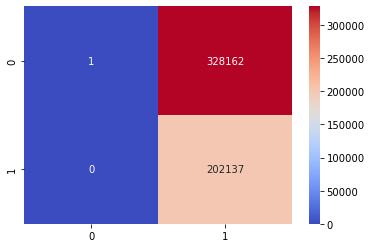

In [95]:
y_pred2 = model.predict(x)
y_test2 = pd.DataFrame(y)
cm2 = confusion_matrix(y_test2, y_pred2.round())
sns.heatmap(cm2, annot=True, fmt='.0f', cmap='coolwarm')
plt.show()

In [96]:
scoreNew = model.evaluate(x, y)
print('Test Accuracy: {:.2f}%\nTest Loss: {}'.format(scoreNew[1]*100,scoreNew[0]))

16572/16572 [==============================] - 28s 2ms/step - loss: 0.6948 - accuracy: 0.3812
Test Accuracy: 38.12%
Test Loss: 0.6948111057281494


In [97]:
print(classification_report(y_test2, y_pred2.round()))


              precision    recall  f1-score   support

           0       1.00      0.00      0.00    328163
           1       0.38      1.00      0.55    202137

    accuracy                           0.38    530300
   macro avg       0.69      0.50      0.28    530300
weighted avg       0.76      0.38      0.21    530300



## SVM

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=42)
# Import SVM
from sklearn.svm import SVC
svm = SVC()

In [ ]:



svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Paired_r", linewidth=2, linecolor='w', fmt='.0f')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

In [42]:
# Normalization
X = (x - np.min(x)) / (np.max(x) - np.min(x)).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [ ]:

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='.0f', cmap='brg_r')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

In [ ]:
pickle.dump(svm,open("svm.pkl",'wb'))

In [41]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C':[0.1, 1, 10, 100], 'gamma':[1, 0.1, 0.01, 0.001], 'kernel' : ['rbf', 'poly', 'sigmoid', 'linear']}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=4)
grid.fit(X_train, y_train)
print("Best Parameters: ",grid.best_params_)

NameError: name 'SVC' is not defined

In [ ]:
grid_pred = grid.predict(X_test)
cmNew = confusion_matrix(y_test, grid_pred)
sns.heatmap(cmNew, annot=True, fmt='.0f', cmap='gray_r')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

In [ ]:
print(classification_report(y_test, grid_pred))


In [3]:
server = "database-1.cn5t11g2iaps.us-east-1.rds.amazonaws.com"
database = "db1"
username = "admin"
password = "Digitalit123"
import pyodbc
cnxn = pyodbc.connect('Driver={SQL Server};SERVER='+server+';DATABASE='+database+';uid='+username+';pwd='+ password) 




In [10]:
print('Driver={SQL Server};SERVER='+server+';DATABASE='+database+';uid='+username+';pwd='+ password)

Driver={SQL Server};SERVER=database-1.cn5t11g2iaps.us-east-1.rds.amazonaws.com;DATABASE=db1;uid=admin;pwd=Digitalit123


In [5]:
import pandas as pd

query_input = "SELECT * FROM db1.dbo.unseendata"

data = pd.read_sql(str(query_input), cnxn)


FileNotFoundError: [Errno 2] No such file or directory: 'data/main_data.csv'

In [6]:
data.head()

,InscClaimAmtReimbursed,EncounterType,Gender,Race,RenalDiseaseIndicator,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,...,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,IsDead,DaysAdmitted,TotalDiagnosis,TotalProcedure
0,0,1,1,1,0,2,1,2,2,1,...,2,0,0,280,70,70,0,0,2,0
1,1100,1,1,1,0,2,1,1,2,1,...,2,7420,1068,2170,220,67,0,0,2,0
2,80,1,1,1,1,1,1,1,2,1,...,2,14700,1868,2760,800,95,0,0,4,0
3,70,1,2,1,0,1,1,1,1,1,...,2,0,0,830,490,90,0,0,4,0
4,300,1,2,3,1,1,1,1,2,2,...,2,0,0,20550,5040,75,0,0,3,0


In [13]:
str1 = "Driver={SQL Server};SERVER="

In [14]:
len(str1)

27

In [15]:
str2 = "Driver={SQL Server};SERVER=database-1.cn5t11g2iaps.us-east-1.rds.amazonaws.com;Database="

In [16]:
len(str2)

88